In [1]:
import os, glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool

from sklearn.tree import DecisionTreeClassifier
from scipy import ndimage, signal
from skimage import measure

In [5]:
def load_image(path): 
    image = Image.open(path).convert('RGB')
    image = np.array(image).astype(float) / 255
    return image

def load_mask(path): 
    mask = Image.open(path).convert('1')
    mask = np.array(mask) > 0
    mask = ndimage.binary_fill_holes(mask)
    mask = ndimage.binary_dilation(mask, iterations=2)
    mask = ndimage.binary_erosion(mask, iterations=2)
    return mask

def predict(image, model):
    pred = model.predict(image.reshape(-1, 3)).reshape(image.shape[:-1])
    return pred

def process(pred):
    pred = ndimage.binary_dilation(pred, iterations=2)
    pred = ndimage.binary_fill_holes(pred)
    pred = ndimage.binary_erosion(pred, iterations=2)
    pred = measure.label(pred, connectivity=1)
    counts = np.unique(pred, return_counts=True)
    labels = counts[0][counts[1] > 10000]
    labels = labels[labels > 0]
    pred = np.isin(pred, labels)
    return pred

def min_area_rect(mask):

    # extract objects
    labeled_array, n_objects = ndimage.label(mask > 0.5)
    objects = ndimage.find_objects(labeled_array)

    # sort objects left to right
    sort = np.argsort([objects[i][1].start for i in range(n_objects)])
    objects = [objects[i] for i in sort]

    # get min area rectangles
    boxes, rects = [], []
    for o in objects:
        leaf = mask[o].astype(np.uint8)
        contours, _ = cv2.findContours(leaf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        rect = cv2.minAreaRect(contours[0]) # (center(x, y), (width, height), angle of rotation)
        r_min, c_min = o[0].start, o[1].start # get row and column offset
        box = cv2.boxPoints(rect)
        box = box + np.array([c_min, r_min]) # adjust center to image coordinates
        box = np.int0(box)
        boxes.append(box)
        rects.append(rect)

    return objects, rects, boxes

def largest(objects, rects, boxes):
    idx = np.argmax([r[1][0] * r[1][1] for r in rects])
    return [objects[idx]], [rects[idx]], [boxes[idx]]

def extract_leaves(image, mask):

    # get min area rectangles
    objects, rects, _ = min_area_rect(mask)

    # extract leaves
    leaves = []
    for o, r in zip(objects, rects):

        # slice out leaf
        leaf_img, leaf_msk = image[o].copy(), mask[o].copy() > 0.5

        # do final size check
        if leaf_msk.sum() < 10000: continue
        
        # kill background
        leaf_img[leaf_msk == 0] = 0

        # extract values for transformation
        h, w, _ = leaf_img.shape
        l = int((w**2 + h**2)**0.5)
        angle = r[-1]
        center = (int(l/2), int(l/2))

        # pad leaf to square
        r_pad, c_pad = int((l - h) / 2) + 1, int((l - w) / 2) + 1
        leaf_img = np.pad(leaf_img, ((r_pad, r_pad), (c_pad, c_pad), (0, 0)), mode='constant')

        # create a rotation matrix and rotate the image
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        leaf_img = cv2.warpAffine(leaf_img, M, (l, l))

        # crop the image
        coords = np.argwhere(leaf_img.sum(-1) > 0)
        r_min, r_max = coords[:, 0].min(), coords[:, 0].max()+1
        c_min, c_max = coords[:, 1].min(), coords[:, 1].max()+1
        leaf_img = leaf_img[r_min:r_max, c_min:c_max]

        # rotate so long axis is horizontal
        if leaf_img.shape[0] > leaf_img.shape[1]:
            leaf_img = np.rot90(leaf_img)

        # flip so leaf tip is to the right
        leaf_img = np.fliplr(leaf_img)
        
        leaves.append(leaf_img)
    
    return leaves

def extract_features(leaf, px_to_cm=1):

    # extract region props
    leaf_mask = (leaf.sum(axis=2) > 0).astype(np.uint8)
    leaf_props = measure.regionprops(leaf_mask)[0]
    leaf_max_width = (leaf.sum(axis=2) > 0).sum(axis=0).max() * px_to_cm

    # get area, perimeter, and lengths
    area = leaf_props.area * px_to_cm**2
    perimeter = leaf_props.perimeter * px_to_cm
    # eccentricity = leaf_props.eccentricity
    # solidity = leaf_props.solidity
    feret_length = leaf_props.major_axis_length * px_to_cm
    max_width = leaf_max_width

    # get colors
    leaf_colors = leaf[leaf_mask > 0]
    R, G, B = leaf_colors.mean(axis=0)
    H, S, V = matplotlib.colors.rgb_to_hsv([R, G, B])

    return area, perimeter, feret_length, max_width, R, G, B, H, S, V

# Train classifier for leaf and label detection

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

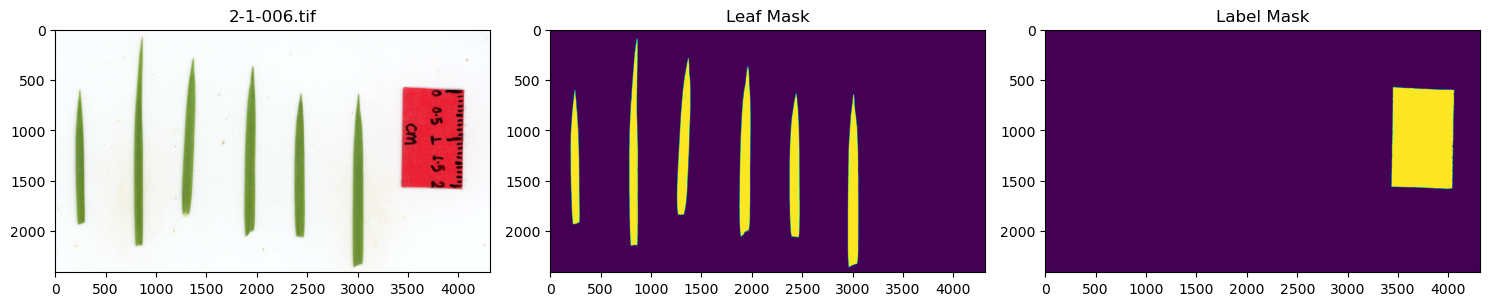

In [6]:
#
# load data
#

# options
image_path = '../data/raw/zoysiagrass/images/'
leaf_mask_path = '../data/raw/zoysiagrass/leaf_masks/'
label_mask_path = '../data/raw/zoysiagrass/label_masks/'
image_files = sorted([os.path.basename(f) for f in glob.glob(leaf_mask_path + '*.tif')])

# load images and masks
images = [load_image(image_path + f) for f in tqdm(image_files)]
leaves = [load_mask(leaf_mask_path + f) for f in tqdm(image_files)]
labels = [load_mask(label_mask_path + f) for f in tqdm(image_files)]

# check that shapes are the same
assert all([i[:, :, 0].shape == l.shape and i[:, :, 0].shape == m.shape for i, l, m in zip(images, leaves, labels)])

# plot example
rand_idx = np.random.randint(len(image_files))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(images[rand_idx])
ax[0].set_title(image_files[rand_idx])
ax[1].imshow(leaves[rand_idx])
ax[1].set_title('Leaf Mask')
ax[2].imshow(labels[rand_idx])
ax[2].set_title('Label Mask')
plt.tight_layout()
plt.show()

Training leaf classifier...
Accuracy: 99.36%
Plotting examples...


  0%|          | 0/5 [00:00<?, ?it/s]

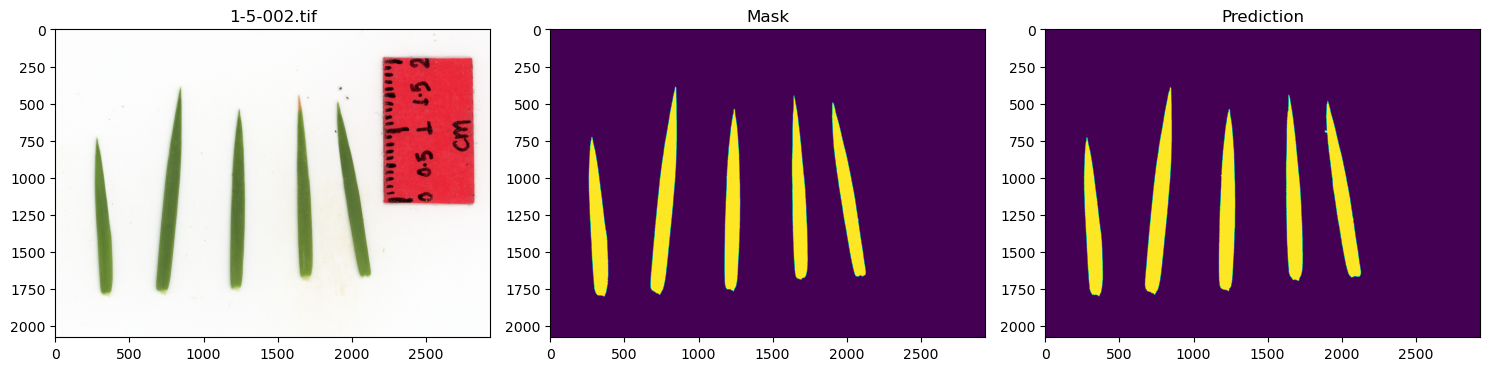

In [10]:
#
# train classifier
#

# options
leaf = True # leaf or label
rand_seed = 42
np.random.seed(rand_seed)
plot = True
save = False
save_path = '../data/raw/zoysiagrass/leaf_preds/' if leaf else '../data/raw/zoysiagrass/label_preds/'

# flatten image into [pixels, channels]
X = np.concatenate([i.reshape(-1, 3) for i in images])
y = np.concatenate([l.reshape(-1) for l in leaves]) if leaf else np.concatenate([l.reshape(-1) for l in labels])

# check that shapes are the same
assert X.shape[0] == y.shape[0]

# subsample data
pos_idx = np.random.choice(np.argwhere(y == 1).flatten(), 100000, replace=False)
neg_idx = np.random.choice(np.argwhere(y == 0).flatten(), 100000, replace=False)
idx = np.concatenate([pos_idx, neg_idx])

# train decision tree
print('Training leaf classifier...')
model = DecisionTreeClassifier(max_depth=5, random_state=rand_seed).fit(X[idx], y[idx])
print('Accuracy: {:.2f}%'.format(model.score(X[idx], y[idx]) * 100))

if plot:

    print('Plotting examples...')

    # make predictions on whole images
    y_preds = [process(predict(i, model)) for i in tqdm(images)]

    # plot leaf/prediction overlays
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[i])
        ax[0].set_title(image_files[i])
        if leaf: ax[1].imshow(leaves[i])
        if not leaf: ax[1].imshow(labels[i])
        ax[1].set_title('Mask')
        ax[2].imshow(y_preds[i])
        ax[2].set_title('Prediction')
        plt.tight_layout()
        plt.show()

        break

if save:

    print('Making predictions...')

    # get all image names
    all_images = sorted([os.path.basename(f) for f in glob.glob(image_path + '*.tif')])

    # make predictions on all images
    for path in tqdm(all_images):
        image = load_image(image_path + path)
        pred = process(predict(image, model))
        pred = Image.fromarray((pred * 255).astype(np.uint8))
        pred.save(save_path + path.replace('.tif', '.png'))

# Extract features from leaves and labels

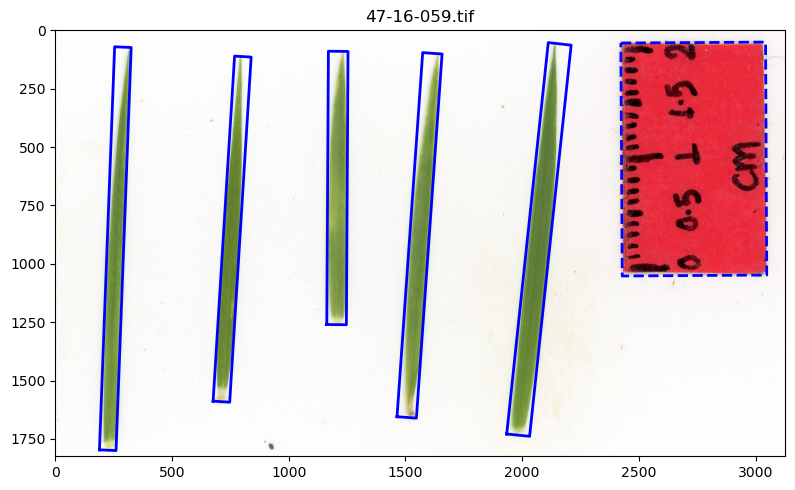

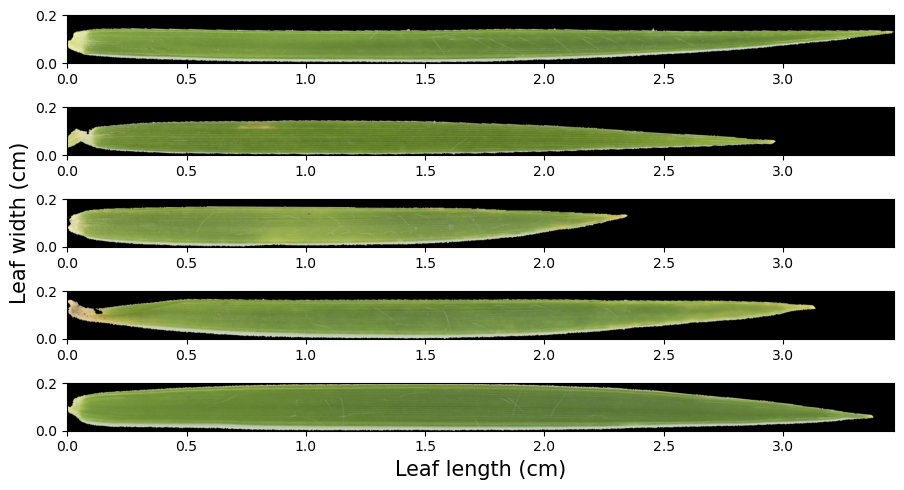

In [11]:
#
# identify leaves and sizing label
#

# options
image_path = '../data/raw/zoysiagrass/images/'
leaf_path = '../data/raw/zoysiagrass/leaf_preds/'
label_path = '../data/raw/zoysiagrass/label_preds/'
all_images = sorted([os.path.basename(f) for f in glob.glob(image_path + '*.tif')])

# pick random image
rand_idx = np.random.choice(len(all_images))
name = all_images[rand_idx]
image = load_image(image_path + name)
leaves = load_mask(leaf_path + name.replace('.tif', '.png'))
label = load_mask(label_path + name.replace('.tif', '.png'))

# get min area rectangles
leaf_objects, leaf_rects, leaf_boxes = min_area_rect(leaves)
label_objects, label_rects, label_boxes = largest(*min_area_rect(label))

# plot image
fig = plt.figure(figsize=(15, 5))
plt.imshow(image)
plt.title(name)
for box in leaf_boxes:
    b = np.concatenate([box, box[:1]], axis=0)
    plt.plot(b[:, 0], b[:, 1], color='b', linewidth=2)
for box in label_boxes:
    b = np.concatenate([box, box[:1]], axis=0)
    plt.plot(b[:, 0], b[:, 1], '--', color='b', linewidth=2)
plt.tight_layout()
plt.show()

# compute conversion factor from pixels to cm
label_cm = 2
label_px = max(label_rects[0][1])
px_to_cm = label_cm / label_px

# plot leaves
leaf_images = extract_leaves(image, leaves)
leaf_lens = [i.shape[1] for i in leaf_images]
leaf_heights = [i.shape[0] for i in leaf_images]
fig, ax = plt.subplots(len(leaf_images), 1, figsize=(15, 5))
for i, leaf in enumerate(leaf_images):
    leaf = np.pad(leaf.copy(), (
        (max(leaf_heights) - leaf.shape[0], 0), 
        (0, max(leaf_lens) - leaf.shape[1]), 
        (0, 0)
        ), mode='constant')
    rows, cols = leaf.shape[:2]
    ax[i].imshow(leaf, extent=[0, cols*px_to_cm, 0, rows*px_to_cm])
    ax[i].set_anchor('W')
    if i == len(leaf_images) - 1:
        ax[i].set_xlabel('Leaf length (cm)', fontsize=15)
    if i == int(len(leaf_images) / 2):
        ax[i].set_ylabel('Leaf width (cm)', fontsize=15)
plt.tight_layout()
plt.show()

In [6]:
#
# extract and save leaf features
#

# options
image_path = '../data/raw/zoysiagrass/images/'
leaf_path = '../data/raw/zoysiagrass/leaf_preds/'
label_path = '../data/raw/zoysiagrass/label_preds/'
all_images = sorted([os.path.basename(f) for f in glob.glob(image_path + '*.tif')])
save = True
save_path = '../reports/tables/'

# extract features from all images and save to csv using pandas
def image_to_df(name):

    # load image, leaves, and labels
    image = load_image(image_path + name)
    leaf_mask = load_mask(leaf_path + name.replace('.tif', '.png'))
    label_mask = load_mask(label_path + name.replace('.tif', '.png'))

    # get min area rectangle for label
    _, label_rects, _ = largest(*min_area_rect(label_mask))

    # compute conversion factor from pixels to cm
    label_cm = 2
    label_px = max(label_rects[0][1])
    px_to_cm = label_cm / label_px

    # separate leaves
    leaves = extract_leaves(image, leaf_mask)

    # extract features
    features = [extract_features(leaf, px_to_cm) for leaf in leaves]

    # add to dataframe
    df = pd.DataFrame({
        'Image ID': [name] * len(features),
        'Leaf ID': range(len(features)),
        'Area (cm^2)': [i[0] for i in features],
        'Perimeter (cm)': [i[1] for i in features],
        'Max Length (cm)': [i[2] for i in features],
        'Max Width (cm)': [i[3] for i in features],
        'Red': [i[4] for i in features],
        'Green': [i[5] for i in features],
        'Blue': [i[6] for i in features],
        'Hue': [i[7] for i in features],
        'Saturation': [i[8] for i in features],
        'Brightness': [i[9] for i in features],
        })
    
    return df

# extract features from all images
with Pool(processes=32) as pool:
    dfs = pool.map(image_to_df, all_images)

# save to csv
df = pd.concat(dfs, axis=0)
if save: df.to_csv(save_path + 'leaf_features.csv', index=False)
df

Image ID  Leaf ID  Area (cm^2)  Perimeter (cm)  Max Length (cm)  \
0       1-5-002.tif        0     0.339224        4.769608         2.154582   
1       1-5-002.tif        1     0.492392        6.341392         2.815563   
2       1-5-002.tif        2     0.407402        5.501629         2.485043   
3       1-5-002.tif        3     0.393575        5.548704         2.487911   
4       1-5-002.tif        4     0.399631        5.724576         2.458190   
..              ...      ...          ...             ...              ...   
1   PI231146001.tif        1     0.434841        7.166510         3.237483   
2   PI231146001.tif        2     0.225310        5.035362         2.464004   
3   PI231146001.tif        3     0.669964       10.451500         5.084123   
4   PI231146001.tif        4     0.232448        5.246592         2.576077   
5   PI231146001.tif        5     0.326293        6.350782         3.031369   

    Max Width (cm)       Red     Green      Blue       Hue  Saturation  \
0         0.212208  0.442832  0.556218  0.275339  0.233947    0.504980   
1         0.222218  0.414413  0.517387  0.277943  0.238342    0.462795   
2         0.214210  0.424645  0.524247  0.277510  0.233946    0.470651   
3         0.214210  0.457738  0.546685  0.277444  0.221727    0.492497   
4         0.214210  0.416366  0.511569  0.267518  0.231682    0.477064   
..             ...       ...       ...       ...       ...         ...   
1         0.171972  0.430391  0.552061  0.272986  0.239329    0.505514   
2         0.119980  0.442631  0.552646  0.282009  0.234418    0.489711   
3         0.165973  0.395591  0.506922  0.265440  0.243506    0.476369   
4         0.115981  0.472138  0.577313  0.311494  0.232611    0.460442   
5         0.135978  0.440059  0.553578  0.298631  0.240877    0.460545   

    Brightness  
0     0.556218  
1     0.517387  
2     0.524247  
3     0.546685  
4     0.511569  
..         ...  
1     0.552061  
2     0.552646  
3     0.506922  
4     0.577313  
5     0.553578  

[1019 rows x 12 columns]

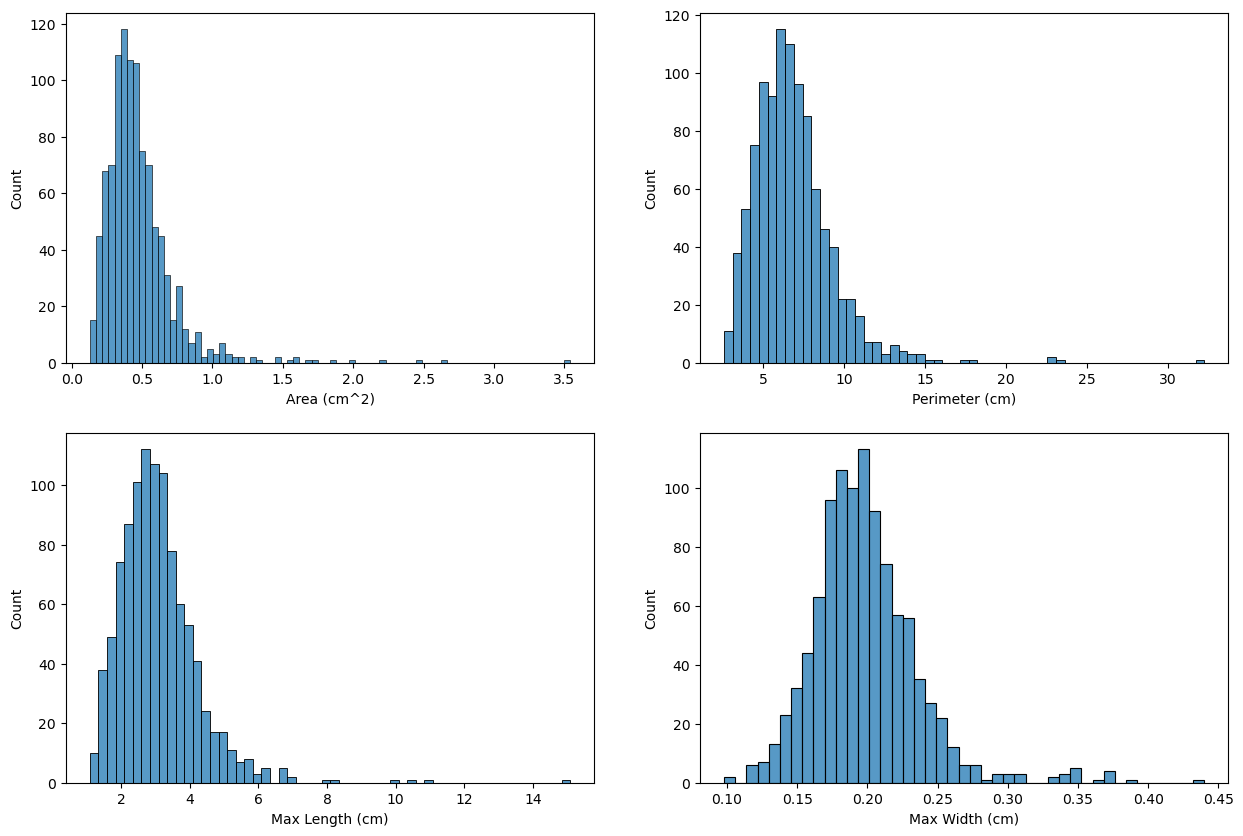

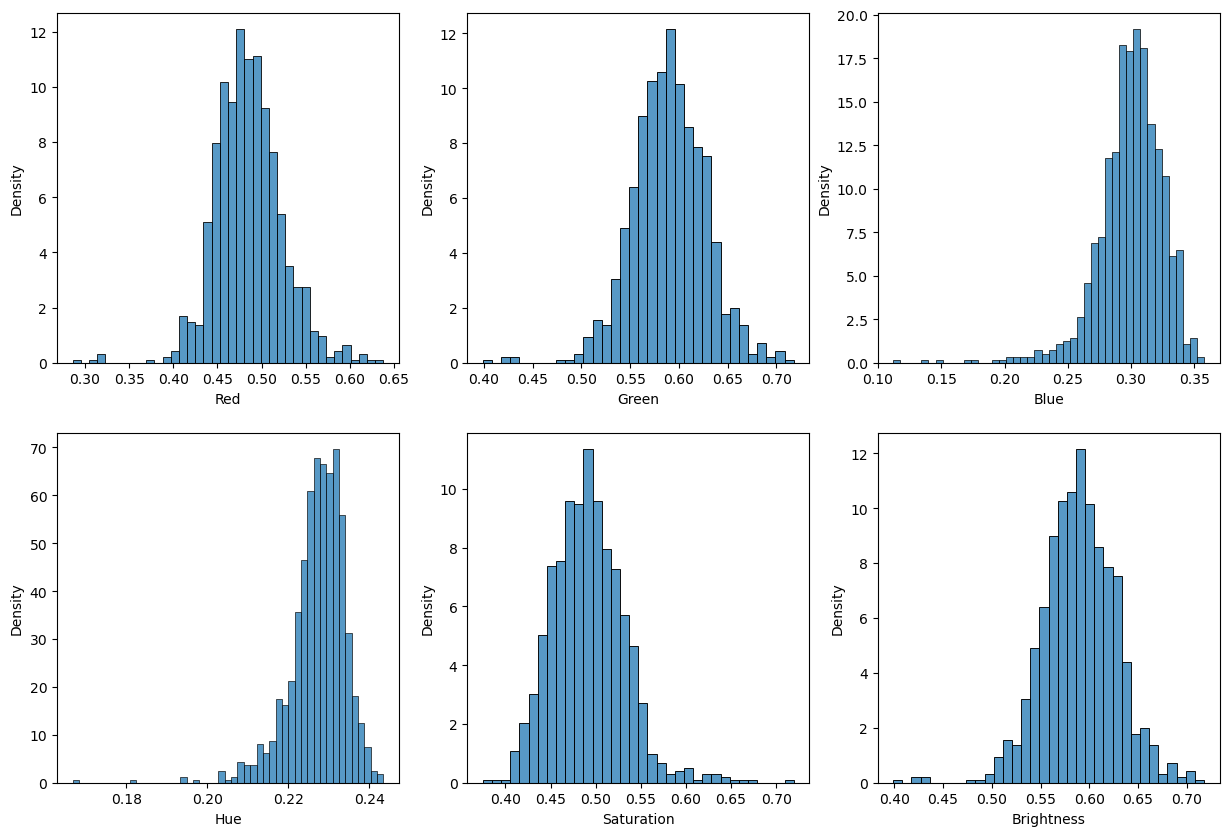

In [11]:
import seaborn as sns

# plot distributions of each morphological feature
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['Area (cm^2)'], ax=ax[0, 0])
sns.histplot(df['Perimeter (cm)'], ax=ax[0, 1])
sns.histplot(df['Max Length (cm)'], ax=ax[1, 0])
sns.histplot(df['Max Width (cm)'], ax=ax[1, 1])
plt.show()

# plot distributions of each color feature
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(df['Red'], stat='density', ax=ax[0, 0])
sns.histplot(df['Green'], stat='density', ax=ax[0, 1])
sns.histplot(df['Blue'], stat='density', ax=ax[0, 2])
sns.histplot(df['Hue'], stat='density', ax=ax[1, 0])
sns.histplot(df['Saturation'], stat='density', ax=ax[1, 1])
sns.histplot(df['Brightness'], stat='density', ax=ax[1, 2])
plt.show()

# Vein counting

In [12]:
# options
image_path = '../data/raw/zoysiagrass/images/'
leaf_path = '../data/raw/zoysiagrass/leaf_preds/'
label_path = '../data/raw/zoysiagrass/label_preds/'

# get manual vein counts and image IDs
vein_counts = {
    '3-15-011.tif': [20, 18, 18, 18, 20, 21],
    '4-7-007.tif':	[18, 23, 22, 19],
    '27-7-048.tif':	[16, 18, 18, 18, 17, 17],
    '45-2-058.tif': [15, 16, 17, 17, 16, 20],
    '59-13-053.tif': [20, 22, 23, 19, 18],
    '69-14-003.tif': [33, 29, 27, 28, 31],
    '66-8-004.tif': [18, 22, 24, 22],
    '71-12-064.tif': [17, 15, 18, 15, 17],
    '81-7-090.tif': [19, 19, 20, 19],
}
vein_images = list(vein_counts)

def count_veins(image_id, prominence=0.025, window=1, plot=False):

    # load image and leaves
    image = load_image(image_path + image_id)
    leaf_mask = load_mask(leaf_path + image_id.replace('.tif', '.png'))
    leaves = extract_leaves(image, leaf_mask)

    leaf_vein_counts = []
    for leaf_idx, leaf_img in enumerate(leaves):

        # get leaf body and location of widest point
        leaf_mask = leaf_img.mean(-1) > 0
        leaf_widths = leaf_mask.sum(0).astype(int)
        max_idx = np.argmax(leaf_widths)

        # count veins along leaf body cross sections
        widths, peaks, counts = [], [], []
        for col in range(leaf_img.shape[1]):
            x = np.arange(leaf_widths[col]+1)
            if window == 0: 
                y = leaf_img[:, col].mean(-1)
            else:
                start = max(0, col - window)
                stop = min(leaf_mask.shape[1], col + window + 1)
                y = leaf_img[:, start:stop].mean(-1).mean(-1)
            peak = signal.find_peaks(-y, prominence=prominence)[0]
            widths.append(x)
            peaks.append(peak)
            counts.append(len(peak))

        if plot:
            fig, axs = plt.subplots(2, 1, figsize=(15, 3))
            axs[0].imshow(leaf_img)
            axs[1].plot(counts)
            axs[1].axvline(np.argmax(counts), color='red', linestyle='--', ymax=np.max(counts)/35)
            axs[1].axhline(np.max(counts), color='red', linestyle='--', xmax=np.argmax(counts)/len(counts))
            plt.xlim(0, leaf_img.shape[1])
            plt.ylim(0, 40)
            plt.yticks(range(0, 41, 10))
            plt.show()

        leaf_vein_counts.append(max(counts))

    return leaf_vein_counts


# count_veins(vein_images[-4], prominence=0.025, window=1, plot=True)

# do grid search to find best prominence and window size
prominences = [0.01, 0.015, 0.02, 0.025, 0.03]
windows = [0, 1, 3, 5]

# compute mean absolute error for each prominence and window size
def loss(prominence, window):
    pred_counts = sum([count_veins(image_id, prominence, window) for image_id in vein_images], [])
    true_counts = sum([vein_counts[image_id] for image_id in vein_images], [])
    return np.mean(np.abs(np.array(pred_counts) - np.array(true_counts)))
losses = np.zeros([len(prominences), len(windows)])
for i, p in enumerate(tqdm(prominences)):
    for j, w in enumerate(tqdm(windows)):
        losses[i, j] = np.round(loss(p, w), 4)

# find and print argmin
i, j = np.argwhere(losses == np.min(losses))[0]
print('prominence: {}, window-size: {}, mae: {:.4f}'.format(
    prominences[i], 
    windows[j], 
    losses[i, j]))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

prominence: 0.015, window-size: 3, mae: 1.5556


In [4]:
#
# count veins for all images with best hyperparameters
#

# options
all_images = sorted([os.path.basename(f) for f in glob.glob(image_path + '*.tif')])
save = True
save_path = '../reports/tables/'

# best parameters
prominence = 0.015
window = 3

# count veins
vein_counts = {}
for i in tqdm(range(len(all_images))):
    image_id = all_images[i]
    vein_counts[image_id] = count_veins(image_id, prominence, window)

# convert vein counts to dataframe with columns [Image ID, Leaf ID, Vein Count]
image_ids, leaf_ids, veins = [], [], []
for image_id in vein_counts:
    for leaf_id, vein_count in enumerate(vein_counts[image_id]):
        image_ids.append(image_id)
        leaf_ids.append(leaf_id)
        veins.append(vein_count)
df = pd.DataFrame({'Image ID': image_ids, 'Leaf ID': leaf_ids, 'Vein Count': veins})
if save: df.to_csv(save_path + 'vein_counts.csv', index=False)

  0%|          | 0/193 [00:00<?, ?it/s]

In [5]:
i = np.argmax(veins)
image_ids[i], leaf_ids[i], veins[i]

('67-3-005.tif', 1, 41)

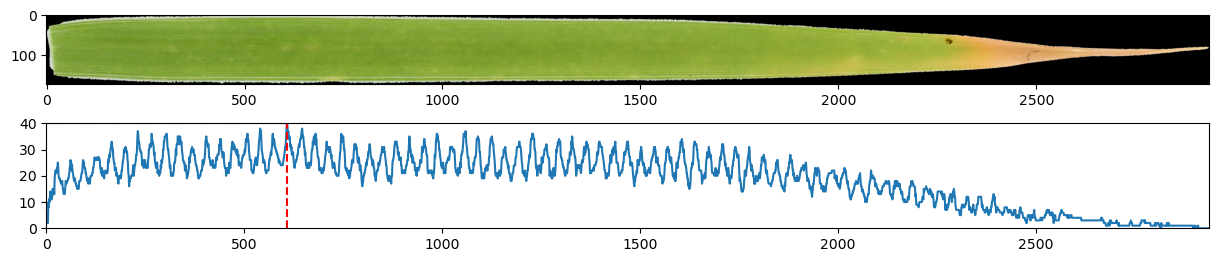

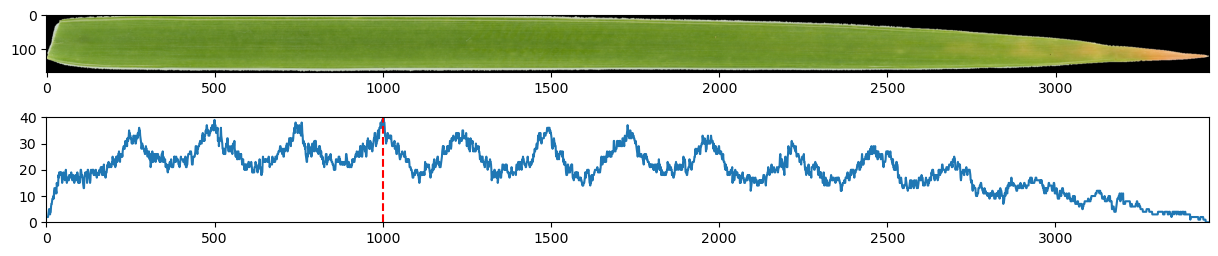

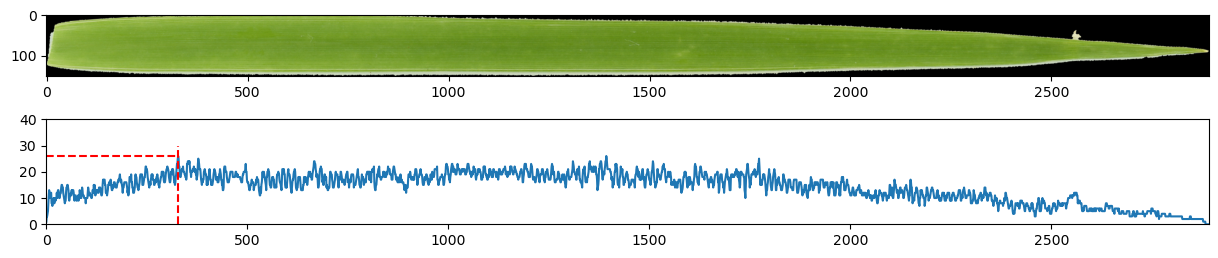

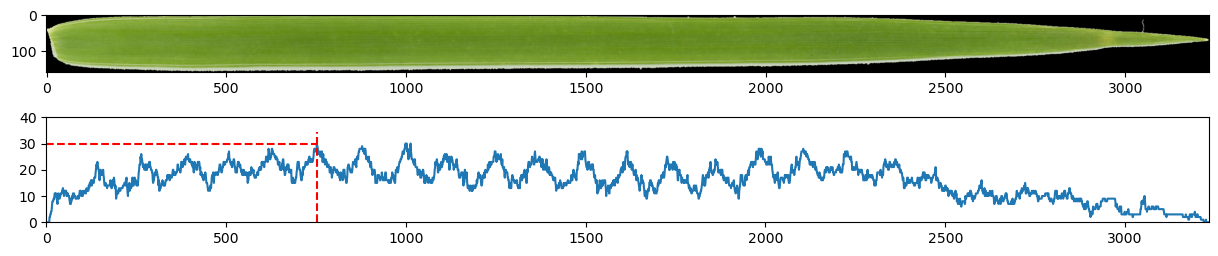

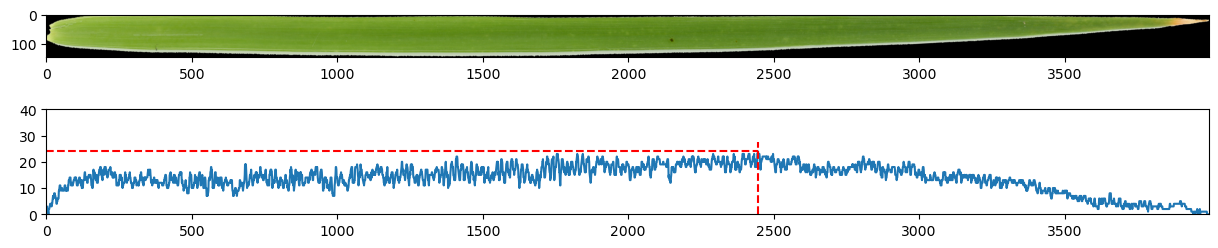

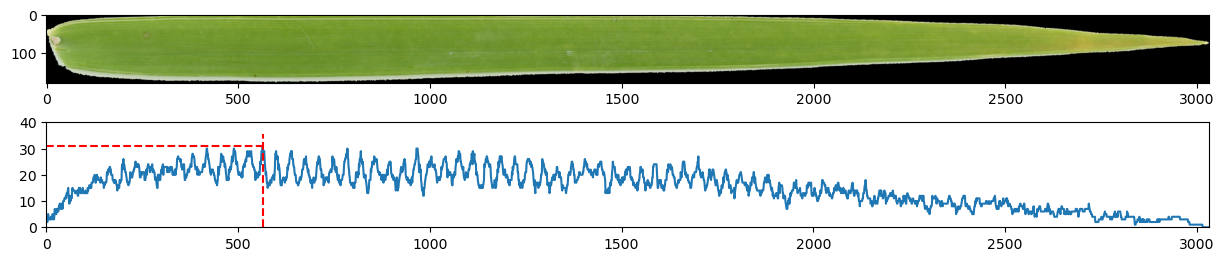

[40, 41, 26, 30, 24, 31]

In [6]:
count_veins(image_ids[i], prominence, window, plot=True)

  0%|          | 0/2063 [00:00<?, ?it/s]

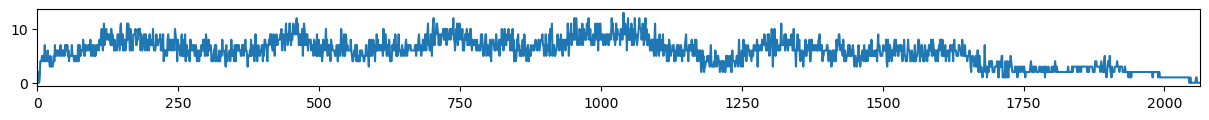

In [ ]:
# count veins along leaf body
counts, peaks = [], []
for col in tqdm(range(l.shape[1])):

    # count veins in cross section
    y = l[:, col].mean(-1)
    peak = signal.find_peaks(-y, prominence=0.025)[0]
    counts.append(len(peak))
    peaks.append(peak)

plt.figure(figsize=(15, 1))
plt.plot(counts)
plt.xlim(0, l.shape[1])
plt.show()

In [ ]:
manual_vein_counts = {
    '1-5-002.tif':  [18, 15, 15, 16, 16],
    '2-1-006.tif':  [16, 15, 18, 21],
    '2-5-001.tif':  [],
    '2-7-008.tif':  [18, 16, 18, 16, 17, 17],
    '2-10-007.tif': [],
}

# Leaf detection

In [ ]:
# general
import os, sys, glob, pdb, time
import numpy as np
from tqdm.notebook import tqdm
from importlib import reload
from multiprocessing import Pool
import socket
from scipy.interpolate import UnivariateSpline

# image processing
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy import ndimage
from scipy import signal
from skimage import measure
from skimage.transform import rotate
from skimage.morphology import skeletonize

# pytorch
import torch, torchvision, torchinfo

if 'bsd-a100' in socket.gethostname():
    base_path = '/mnt/DGX01/Personal/lagergrenj/Codebase/'
elif 'jupyter-lagergrenj' in socket.gethostname():
    base_path = '/gpfs/alpine/syb105/proj-shared/Personal/lagergrenj/Codebase/'
    
sys.path.append(base_path)

In [ ]:
def grayscale(rgb, custom=False):
    if custom:
        gray = (rgb * np.array([[[0.2989, 0.5870, 0.1140]]])).sum(-1)
    else:
        gray = rgb.mean(-1)
    return gray

def detect_threshold(image, tol=1e-4, maxiter=10):
    old_threshold = image.mean()
    for i in range(maxiter):
        new_threshold = np.mean([
            image[image<=old_threshold].mean(),
            image[image>old_threshold].mean()])
        if np.abs(new_threshold - old_threshold) < tol:
            break
        old_threshold = new_threshold
    return new_threshold

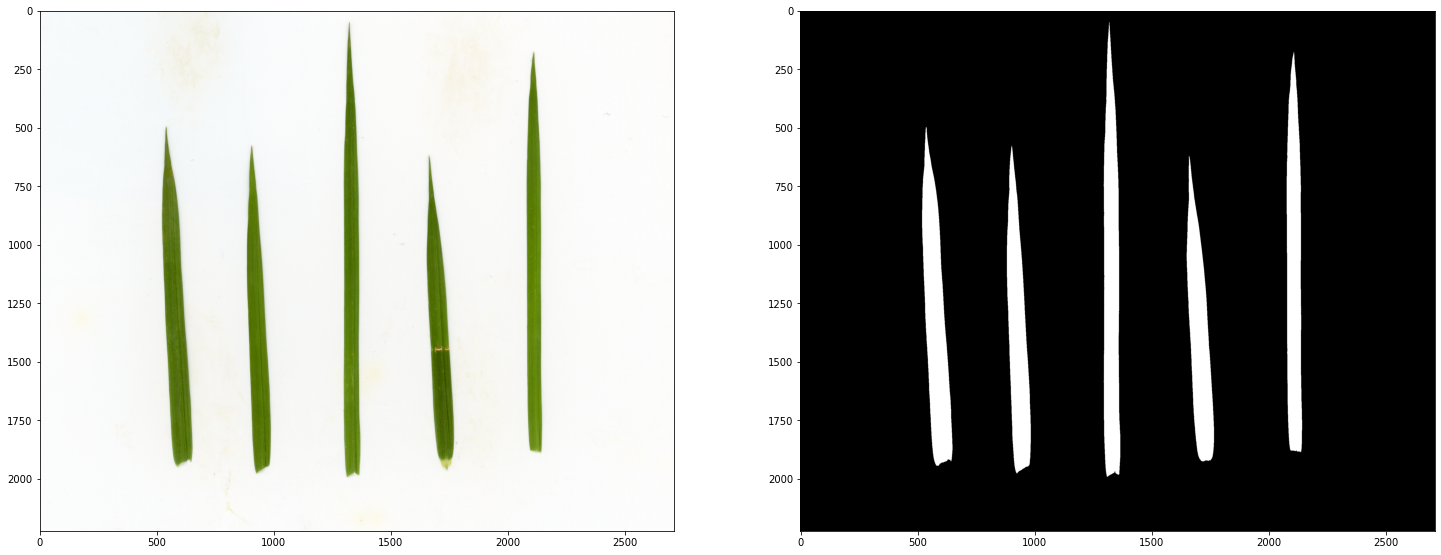

600: [32, 28, 24, 27, 24]


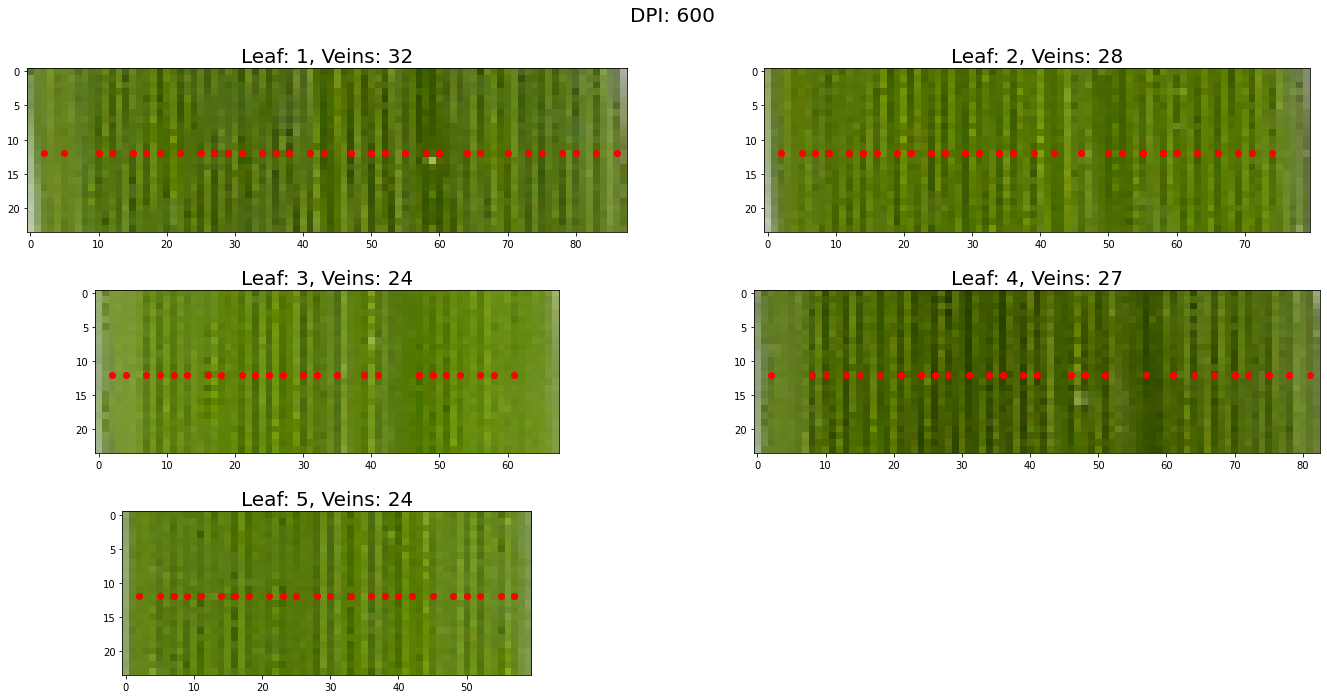

800: [34, 31, 31, 32, 24]


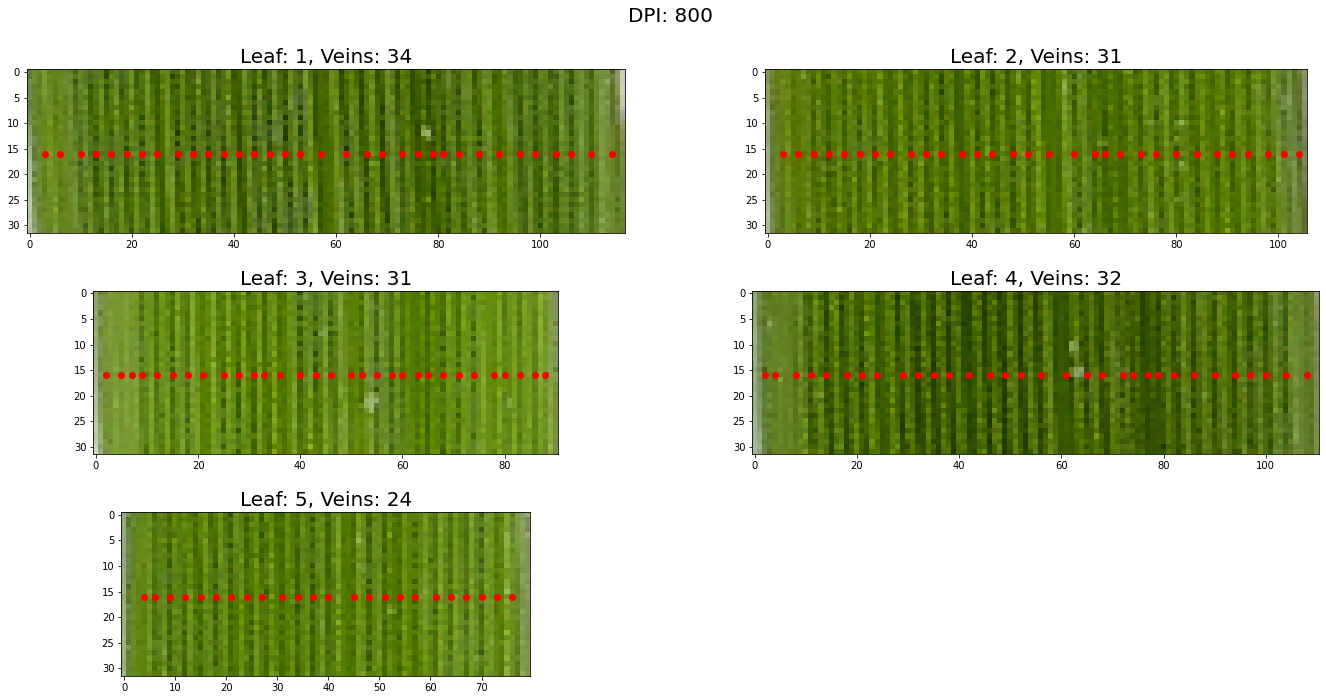

1200: [36, 32, 31, 34, 26]


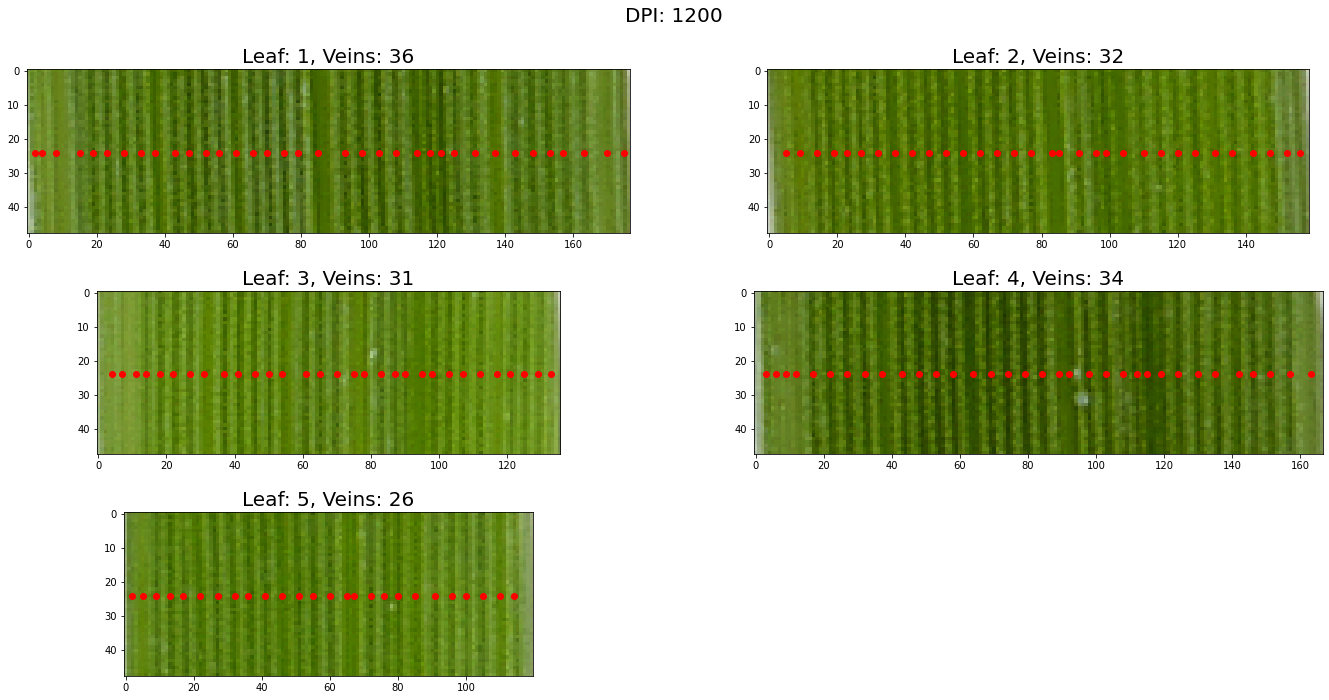

/gpfs/alpine/syb105/proj-shared/Personal/lagergrenj/Libraries/Jupyter/venv/lib/python3.10/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (96409013 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


2400: [36, 32, 35, 34, 30]


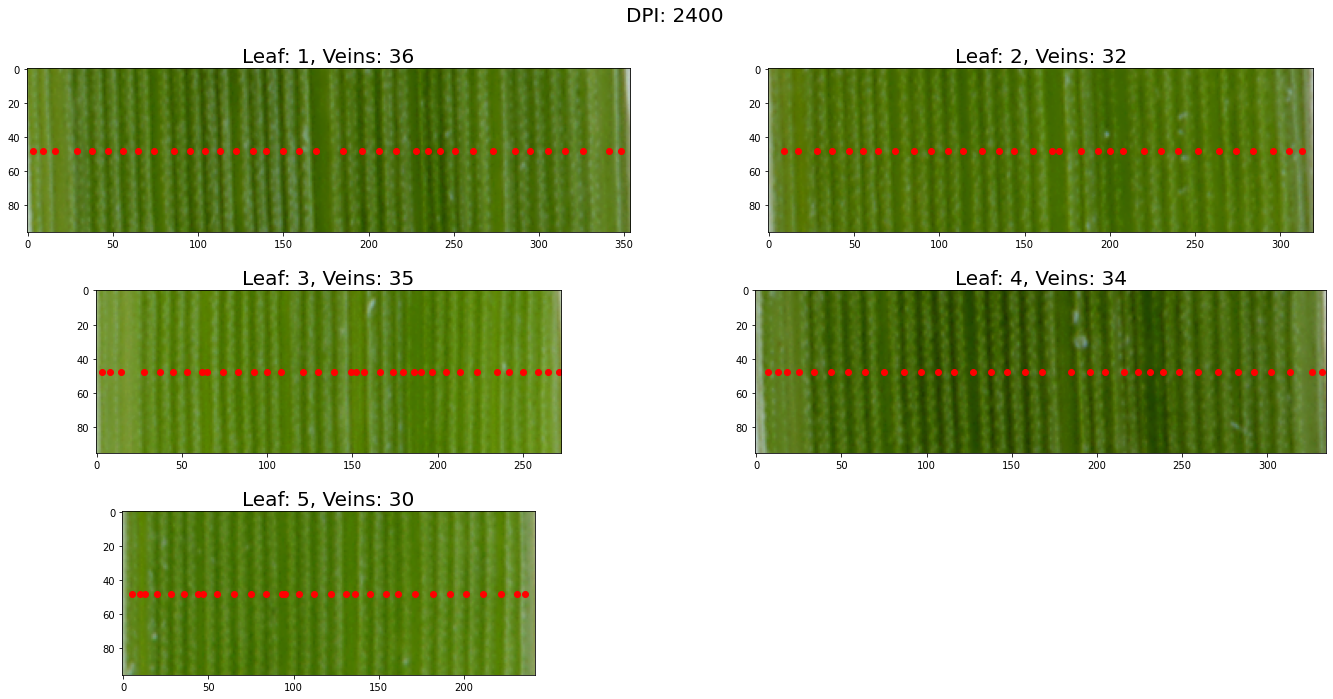

In [ ]:
# options
image_path = base_path + 'Data/Phenotype/UGA/zoysiagrass/scans/'
dpis = ['600', '800', '1200', '2400']
image_names = [os.path.basename(f) for f in glob.glob(image_path+'*')]

for idx, dpi in enumerate(dpis):

    # load image
    #dpi = dpis[0]
    image_name = [i for i in image_names if dpi in i][0]
    image = np.array(Image.open(image_path+image_name))
    #print('image: {0}'.format(image.shape))

    # auto threshold
    gray = grayscale(image)
    threshold = detect_threshold(gray)
    mask = gray <= threshold
    mask = ndimage.binary_fill_holes(mask)
    #print('mask: {0}'.format(mask.shape))

    # filter objects by size
    labeled_array, num_features = ndimage.label(mask>0.5)
    index = torch.tensor(labeled_array, dtype=torch.long).reshape(-1)
    src = torch.ones_like(index)
    sizes = torch.zeros(index.max()+1, dtype=torch.long)
    sizes = sizes.scatter_add(dim=0, index=index, src=src)
    sizes = sizes.detach().cpu().numpy()
    labels = np.arange(len(sizes))[np.argsort(sizes)[::-1]][1:]
    sizes = sizes[np.argsort(sizes)[::-1]][1:]
    mask = np.zeros_like(mask)
    for l, s in zip(labels, sizes):
        if s > 1e4:
            mask[labeled_array == l] = 1
            
    if idx == 0:
        fig = plt.figure(figsize=[25, 25])
        fig.add_subplot(1, 2, 1)
        plt.imshow(image)
        fig.add_subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.show()

    # extract remaining objects
    labeled_array, n_objects = ndimage.label(mask>0.5)
    objects = ndimage.find_objects(labeled_array)
    sort = np.argsort([objects[i][1].start for i in range(n_objects)])
    objects = [objects[i] for i in sort] # sort objects left to right

    # loop over objects
    rows, col_mins, col_maxs, peaks, counts = [], [], [], [], []
    for o in objects:

        # find widest point
        row = mask[o].sum(1).argmax()
        col_min = np.argwhere(mask[o][row]).min()
        col_max = np.argwhere(mask[o][row]).max()
        rows.append(row + o[0].start)
        col_mins.append(col_min + o[1].start)
        col_maxs.append(col_max + o[1].start)

        # count veins
        n = int(int(dpi)/50)
        x = np.arange(col_max-col_min)
        y = image[o][row-n:row+n, col_min:col_max].mean(0).mean(-1)
        #spl = UnivariateSpline(x, y)#, s=0.01)#; spl.set_smoothing_factor(0.01)
        #xx = np.linspace(0, col_max-col_min, 1000)[1:-1]
        #yy = spl(xx)
        peak = signal.find_peaks(-y)[0]
        counts.append(len(peak))
        peaks.append(peak)
        #print(peak)
        #plt.plot(x, y); plt.plot(peak, y[peak], 'ro'); plt.show()

    ## plot
    #fig = plt.figure(figsize=[image.shape[1]/image.shape[0]*15, 15])
    #fig.add_subplot(1,1,1)
    #plt.imshow(image, aspect='auto')
    #for row, col_min, col_max in zip(rows, col_mins, col_maxs):
    #    plt.plot(col_min, row, 'ro', markersize=10)
    #    plt.plot(col_max, row, 'ro', markersize=10)
    #    plt.plot([col_min, col_max], [row, row], 'r-', linewidth=5)
    #plt.tight_layout(pad=1)
    #plt.show()
    
    print('{0}: {1}'.format(dpi, counts))
    
    # plot
    fig = plt.figure(figsize=[20, 10])
    for i in range(len(rows)):
        fig.add_subplot(3, 2, i+1)
        n = int(int(dpi)/50)
        plt.imshow(image[rows[i]-n:rows[i]+n, col_mins[i]:col_maxs[i]])#, aspect='auto')
        plt.plot(peaks[i], len(peaks[i])*[n], 'ro')
        plt.title('Leaf: {0}, Veins: {1}'.format(i+1, counts[i]), fontsize=20)
    plt.suptitle('DPI: {0}'.format(dpi), fontsize=20)
    plt.tight_layout(pad=2)
    plt.show()

In [ ]:
image_names

['600dpi001.tif', '1200dpi002.tif', '800dpi001.tif', '2400dpi001.tif']

  0%|          | 0/1446 [00:00<?, ?it/s]

  0%|          | 0/1928 [00:00<?, ?it/s]

  0%|          | 0/2892 [00:00<?, ?it/s]

/home/4ml/Libraries/dgx/anaconda/envs/venv/lib/python3.7/site-packages/PIL/Image.py:3014: DecompressionBombWarning: Image size (96409013 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/5784 [00:00<?, ?it/s]

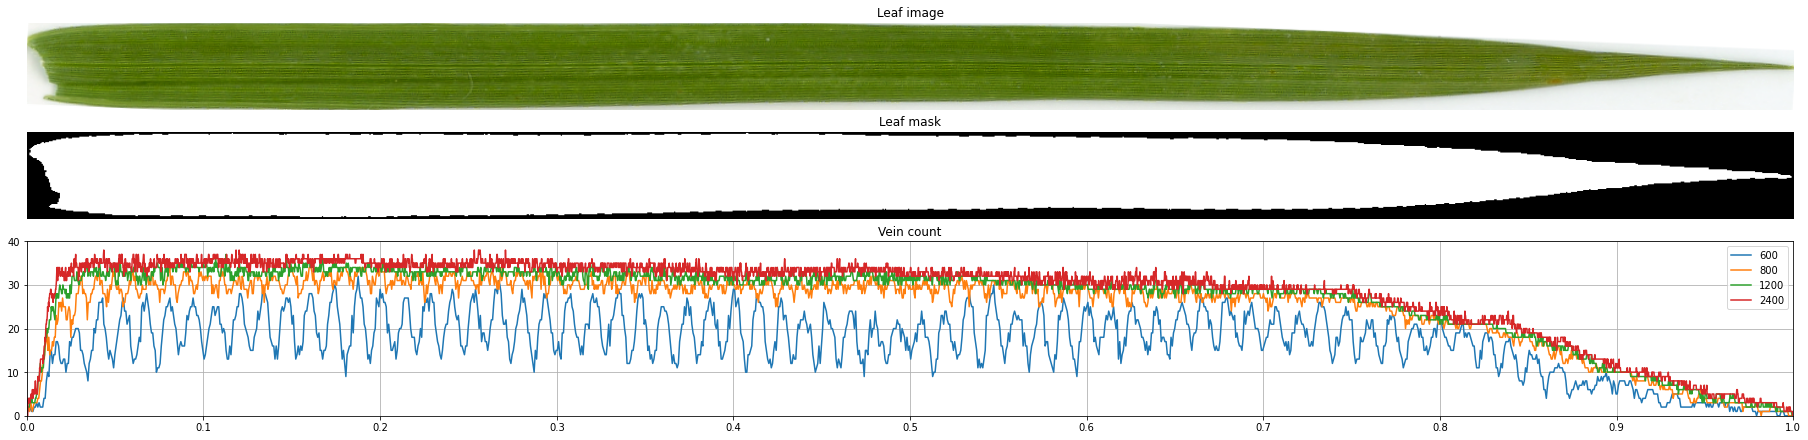

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1864 [00:00<?, ?it/s]

  0%|          | 0/2797 [00:00<?, ?it/s]

/home/4ml/Libraries/dgx/anaconda/envs/venv/lib/python3.7/site-packages/PIL/Image.py:3014: DecompressionBombWarning: Image size (96409013 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/5592 [00:00<?, ?it/s]

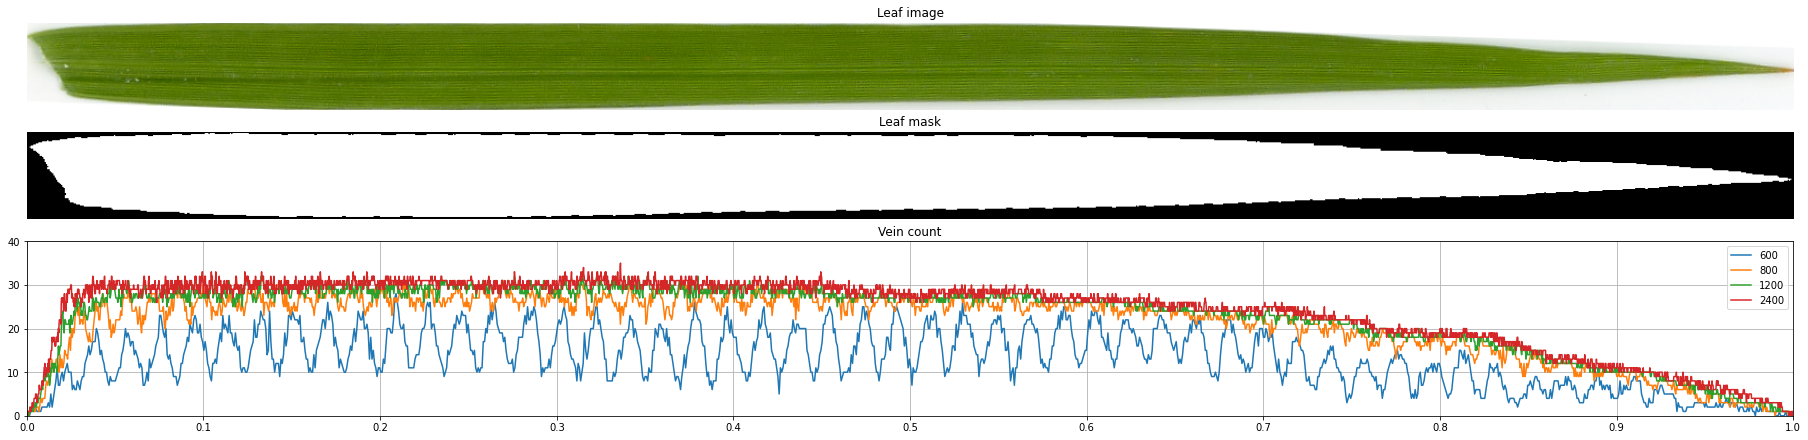

  0%|          | 0/1939 [00:00<?, ?it/s]

  0%|          | 0/2587 [00:00<?, ?it/s]

  0%|          | 0/3880 [00:00<?, ?it/s]

/home/4ml/Libraries/dgx/anaconda/envs/venv/lib/python3.7/site-packages/PIL/Image.py:3014: DecompressionBombWarning: Image size (96409013 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/7758 [00:00<?, ?it/s]

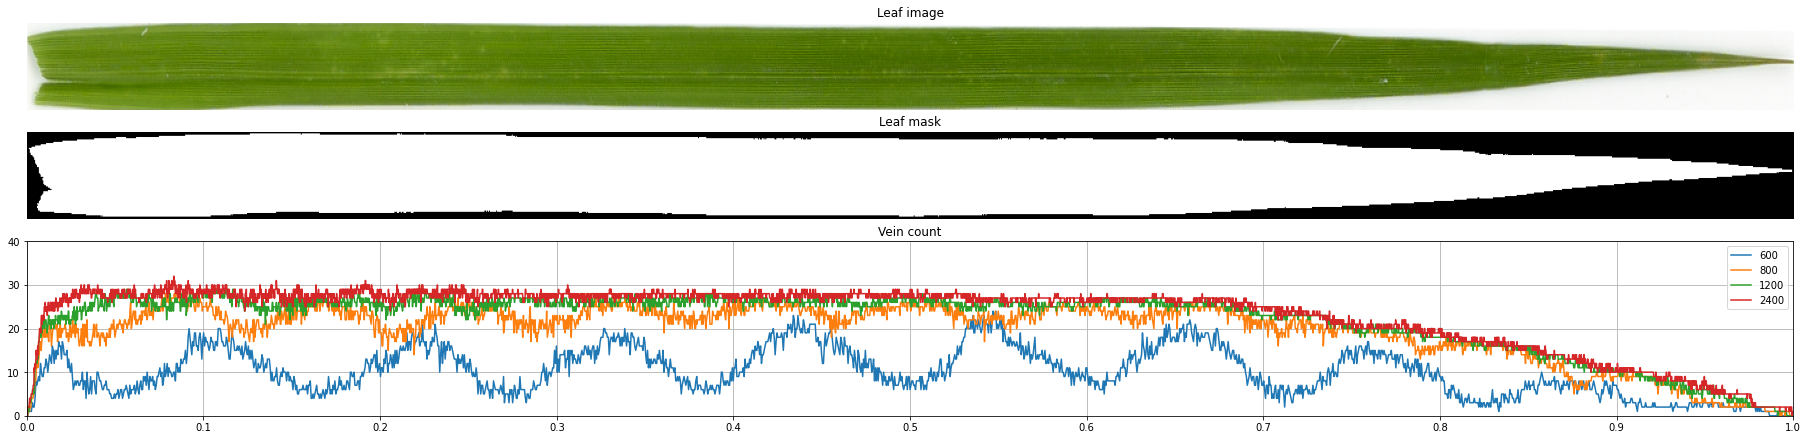

  0%|          | 0/1305 [00:00<?, ?it/s]

  0%|          | 0/1740 [00:00<?, ?it/s]

  0%|          | 0/2611 [00:00<?, ?it/s]

/home/4ml/Libraries/dgx/anaconda/envs/venv/lib/python3.7/site-packages/PIL/Image.py:3014: DecompressionBombWarning: Image size (96409013 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/5221 [00:00<?, ?it/s]

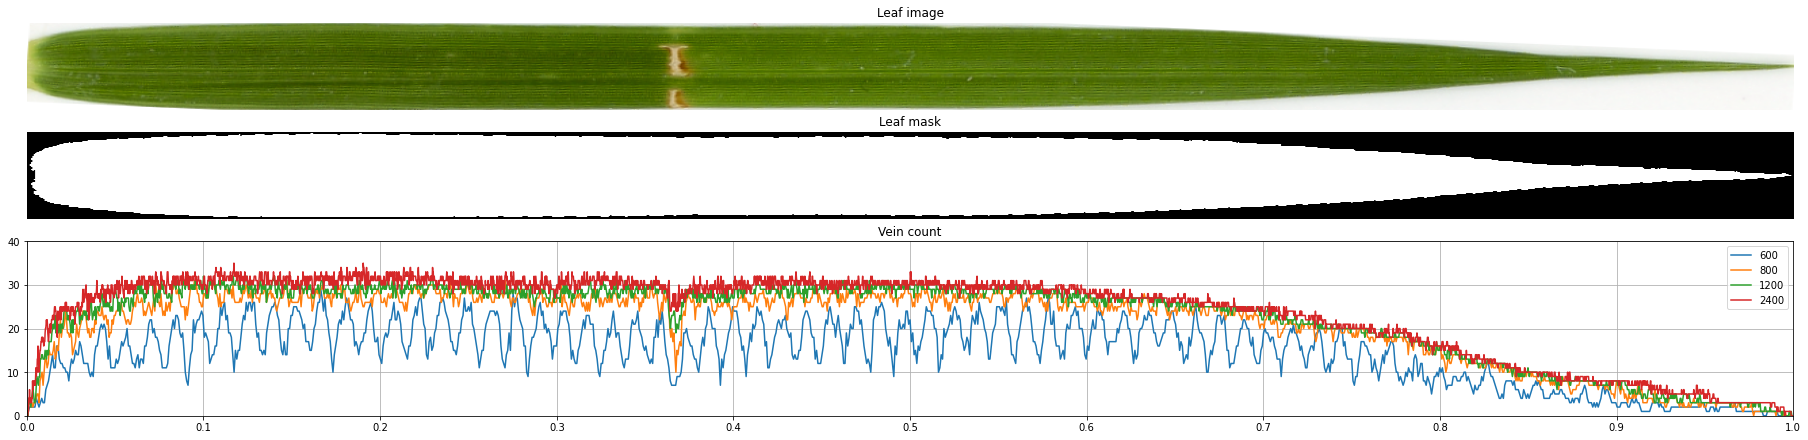

  0%|          | 0/1708 [00:00<?, ?it/s]

  0%|          | 0/2274 [00:00<?, ?it/s]

  0%|          | 0/3412 [00:00<?, ?it/s]

/home/4ml/Libraries/dgx/anaconda/envs/venv/lib/python3.7/site-packages/PIL/Image.py:3014: DecompressionBombWarning: Image size (96409013 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6825 [00:00<?, ?it/s]

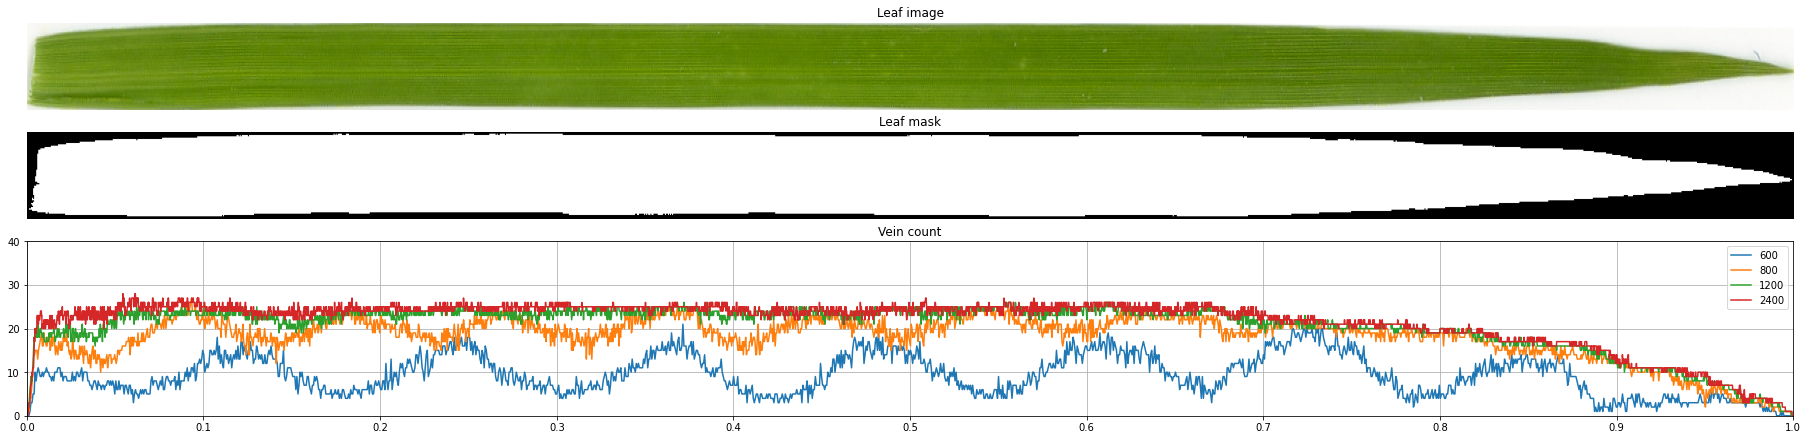

In [ ]:
# options
image_path = base_path + 'Data/Phenotype/UGA/zoysiagrass/scans/'
dpis = ['600', '800', '1200', '2400']
image_names = [os.path.basename(f) for f in glob.glob(image_path+'*')]

# loop over leaf objects
for object_idx in range(5):

    fig = plt.figure(figsize=[25, 6], constrained_layout=True)
    gridspec = fig.add_gridspec(4, 1)
    COUNTS = []
    
    for dpi_idx, dpi in enumerate(dpis):

        # load image
        image_name = [i for i in image_names if dpi in i][0]
        image = np.array(Image.open(image_path+image_name))

        # auto threshold segmentation
        gray = grayscale(image)
        threshold = detect_threshold(gray)
        mask = gray <= threshold
        mask = ndimage.binary_fill_holes(mask)

        # filter objects by size
        labeled_array, num_features = ndimage.label(mask>0.5)
        index = torch.tensor(labeled_array, dtype=torch.long).reshape(-1)
        src = torch.ones_like(index)
        sizes = torch.zeros(index.max()+1, dtype=torch.long)
        sizes = sizes.scatter_add(dim=0, index=index, src=src)
        sizes = sizes.detach().cpu().numpy()
        labels = np.arange(len(sizes))[np.argsort(sizes)[::-1]][1:]
        sizes = sizes[np.argsort(sizes)[::-1]][1:]
        mask = np.zeros_like(mask)
        for l, s in zip(labels, sizes):
            if s > 1e4:
                mask[labeled_array == l] = 1

        # extract leaf objects
        labeled_array, n_objects = ndimage.label(mask>0.5)
        objects = ndimage.find_objects(labeled_array)
        sort = np.argsort([objects[i][1].start for i in range(n_objects)])
        objects = [objects[i] for i in sort] # sort objects left to right
        o = objects[object_idx]

        # rotate by major axis
        orientation = measure.regionprops((mask[o]>0.5).astype(int))[0].orientation
        theta = orientation * (180/np.pi) + 90 
        rot_image = rotate(image[o], -theta, resize=True, cval=1)
        rot_mask = rotate(mask[o], -theta, resize=True, cval=0)

        # clip rotated mask to region of interest
        idx = np.argwhere(rot_mask>0.5).T # [2, N]
        r_min, r_max = idx[0].min(), idx[0].max()
        c_min, c_max = idx[1].min(), idx[1].max()
        rot_image = rot_image[r_min:r_max, c_min:c_max]
        rot_mask = rot_mask[r_min:r_max, c_min:c_max]
        
        if dpi_idx == 0:
            #fig.add_subplot(3, 1, 1)
            fig.add_subplot(gridspec[0:1, :])
            plt.imshow(rot_image, vmin=0, vmax=1, extent=(0, 1, 0, 1), aspect='auto')
            plt.axis('off')
            plt.title('Leaf image')
            #fig.add_subplot(3, 1, 2)
            fig.add_subplot(gridspec[1:2, :])
            pat_mask = np.pad(rot_mask, [[2,2],[2,2]], mode='constant', constant_values=0)
            plt.imshow(pat_mask, cmap='gray', vmin=0, vmax=1, extent=(0, 1, 0, 1), aspect='auto')
            plt.axis('off')
            plt.title('Leaf mask')

        # count veins along leaf body
        counts, peaks = [], []
        for col in tqdm(range(rot_mask.shape[1])):

            # zoom into leaf section
            #n = int(int(dpi)/50)
            c_min = col #max(0, col - n)
            c_max = col + 1 #min(rot_mask.shape[1], col + n)
            idx = np.argwhere(rot_mask[:, c_min:c_max]>0.5).T # [2, N]
            r_min, r_max = idx[0].min(), idx[0].max()

            # count veins
            y = rot_image[r_min:r_max, c_min:c_max].mean(1).mean(-1)
            peak = signal.find_peaks(-y, prominence=0.025)[0]
            counts.append(len(peak))
            peaks.append(peak)
            
        COUNTS.append(counts)
        
    #fig.add_subplot(3, 1, 3)
    fig.add_subplot(gridspec[2:4, :])
    for counts in COUNTS:
        plt.plot(np.linspace(0, 1, len(counts)), counts)
    plt.xlim([0, 1])
    plt.ylim([0, 40])
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 40, 5))
    plt.title('Vein count')
    plt.legend(dpis)
    plt.grid()
    plt.show()